In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import scipy

In [48]:
samplerate_one, one = wavfile.read("Bontempi-B3-C5.wav")
samplerate_two, two = wavfile.read("Ensoniq-ZR-76-03-Dope-85.wav")

samplerate_one = samplerate_one//10
samplerate_two = samplerate_two//10

one = one[::10,0]
two = two[::10,0]

print('Sampling Rate #1 and #2:', samplerate_one, samplerate_two)
print('Audio Shape #1 and #2:', np.shape(one), np.shape(two))

Sampling Rate #1 and #2: 4410 4410
Audio Shape #1 and #2: (7817,) (12445,)


C:\Users\maga-\AppData\Local\Temp\ipykernel_16344\268776877.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate_one, one = wavfile.read("Bontempi-B3-C5.wav")
C:\Users\maga-\AppData\Local\Temp\ipykernel_16344\268776877.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate_two, two = wavfile.read("Ensoniq-ZR-76-03-Dope-85.wav")


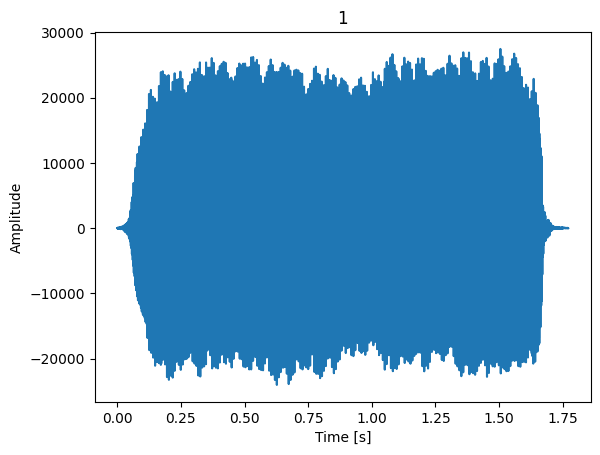

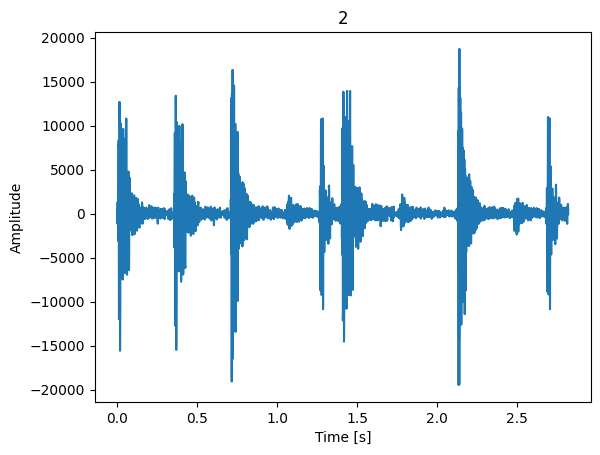

In [63]:
duration = len(one) / samplerate_one
time = np.arange(0, duration, 1 / samplerate_one)

plt.plot(time, one)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('1')
plt.show()

duration = len(two) / samplerate_two
time = np.arange(0, duration, 1 / samplerate_two)

plt.plot(time, two)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('2')
plt.show()

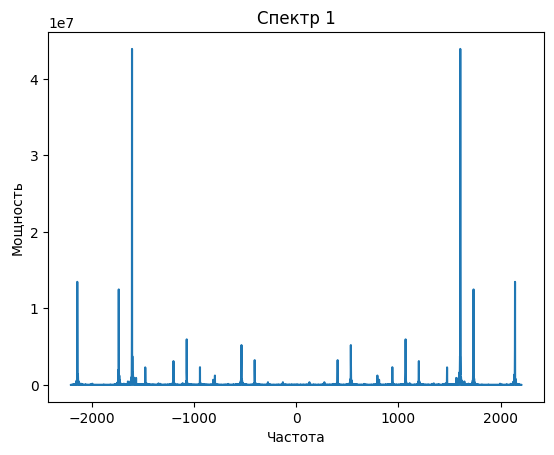

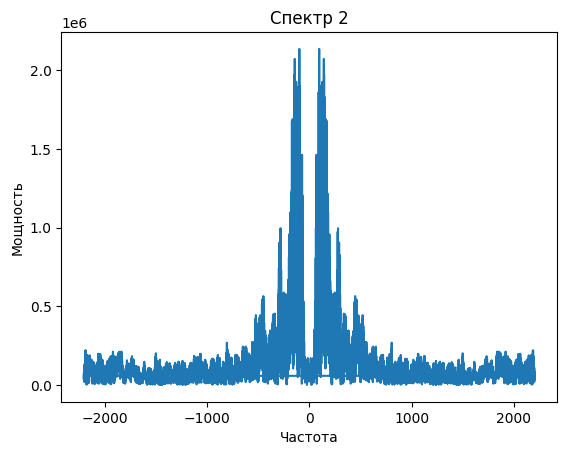

In [64]:
from scipy.fft import fft, fftfreq

duration = len(one) / samplerate_one
N = int(samplerate_one * duration)
yf = fft(one)
xf = fftfreq(N, 1 / samplerate_one)
plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.title('Спектр 1')
plt.show()

duration = len(two) / samplerate_two
N = int(samplerate_two * duration)
yf = fft(two)
xf = fftfreq(N, 1 / samplerate_two)
plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.title('Спектр 2')
plt.show()

In [51]:
def B(x):
    return 1125*np.log(1+x/700)

def rB(x):
    return 700*(np.exp(x/1125)-1)

def f(m,M,f1,fh,Fs,N):
    return N/Fs*rB(B(f1)+m*(B(fh)-B(f1))/(M+1))

def H(k,m,f1,fh,M,N,Fs):
    if k < f(m,M,f1,fh,Fs,N):
        return 0
    elif f(m,M,f1,fh,Fs,N) <= k < f(m+1,M,f1,fh,Fs,N):
        return (k-f(m,M,f1,fh,Fs,N))/(f(m+1,M,f1,fh,Fs,N)-f(m,M,f1,fh,Fs,N))
    elif f(m+1,M,f1,fh,Fs,N) <= k <= f(m+2,M,f1,fh,Fs,N):
        return (f(m+2,M,f1,fh,Fs,N)-k)/(f(m+2,M,f1,fh,Fs,N)-f(m+1,M,f1,fh,Fs,N))
    else:
        return 0
    

In [52]:
def mfccs(a,N,Fs,M,f1,fh):
    x = np.ones(N)
    X = np.zeros([N,2])
    
    for i in range(N):
        Sc = 0
        Ss = 0
        for j in range(N):
            Sc += x[j]*np.cos(2*np.pi*i*j/N)
            Ss += -x[j]*np.sin(2*np.pi*i*j/N)
        X[i,0] = Sc
        X[i,1] = Ss

    S = np.zeros(M)
    
    for i in range(M):
        w = 0
        for j in range(N):
            w += (X[j,0]*X[j,0] + X[j,1]*X[j,1])*H(j,i,f1,fh,M,N,Fs)
        S[i] = np.log(w)

    c = np.zeros(M)

    for i in range(M):
        w = 0
        for j in range(M):
            w += S[j]*np.cos(np.pi*i*(j+1/2)/M)
        c[i] = w

    return c

In [53]:
mfccs1 = mfccs(one,len(one),samplerate_one,26,0,samplerate_one)

In [54]:
mfccs2 = mfccs(two,len(two),samplerate_two,26,0,samplerate_two)

Text(0.5, 1.0, 'Мэл-кепстральные коэффициенты сэплов без первого коэффициента')

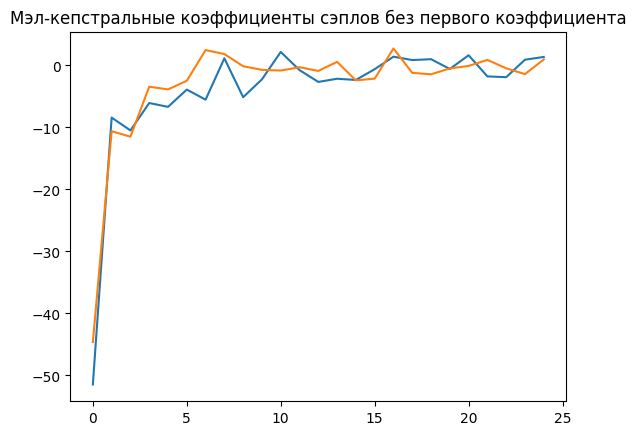

In [58]:
plt.plot(mfccs1[1:])
plt.plot(mfccs2[1:])
plt.title("Мэл-кепстральные коэффициенты сэплов без первого коэффициента")

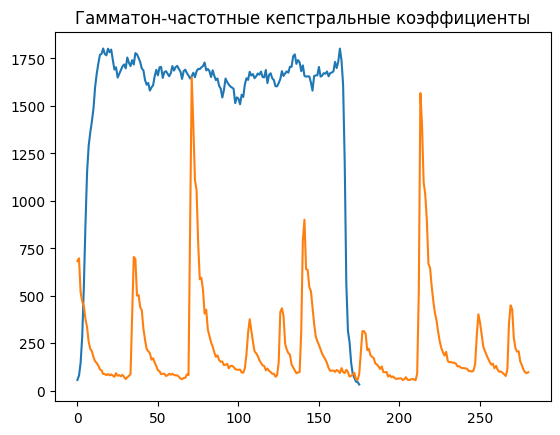

In [60]:
from spafe.features.gfcc import gfcc


gfcc1 = gfcc(one, fs=samplerate_one, num_ceps=1)
plt.plot(gfcc1)
gfcc2 = gfcc(two, fs=samplerate_two, num_ceps=1)
plt.plot(gfcc2)
plt.title('Гамматон-частотные кепстральные коэффициенты')
plt.show()


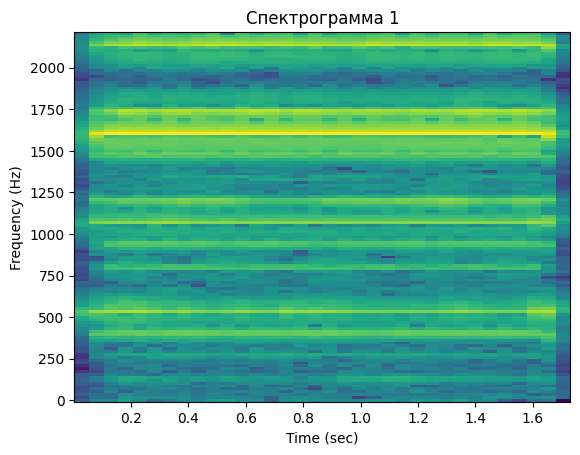

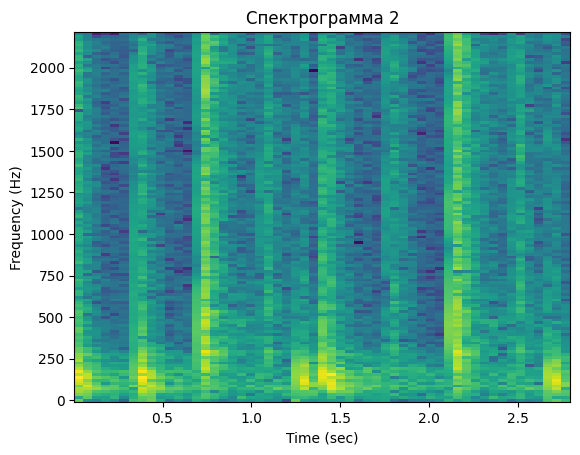

In [62]:

fr, tm, spgram = signal.spectrogram(one,samplerate_one)
lspg = np.log(spgram)
    
plt.pcolormesh(tm,fr,lspg,shading='auto')

plt.title(f'Спектрограмма {1}')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.show()

fr, tm, spgram = signal.spectrogram(two,samplerate_two)
lspg = np.log(spgram)
    
plt.pcolormesh(tm,fr,lspg,shading='auto')

plt.title(f'Спектрограмма {2}')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.show()

In [ ]:
#Звуки сильно отличаются, поэтому их характеристики можно отличить даже на глаз, наверно кроме мэл-кепстральных коэффициентов.
#Но даже в мэл-кепстральных коэффициентах можно уведить разный паттерн поведения линий.